In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso

In [2]:
#load NCAA data
ncaa = pd.read_csv('ncaa_player_stats.csv')

#drop rows without ncaa data
ncaa.dropna(subset=['NCAA_games'], inplace=True)

#select relevant rows
ncaa = ncaa[['college', 'height', 'name', 'position', 'weight', 
'NCAA__3ptapg', 'NCAA__3ptpct', 'NCAA__3ptpg', 'NCAA_fgapg',
'NCAA_fgpct', 'NCAA_fgpg', 'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg']]

In [3]:
#load NBA data
nba = pd.read_csv('nba_player_stats.csv')

#only past 20 years
nba = nba.loc[nba['Year']>=2004,:]

In [4]:
rookies = pd.DataFrame(columns=['name', 'PER', 'rookie_year','age'])

for i in range(len(nba['Player'].unique())):
    p = nba['Player'].unique()[i]
    player = nba.loc[nba['Player']==p,:]
    
    player.reset_index(inplace=True)
    first_year = player.loc[0,'Year']
    
    rookies.loc[i,'name'] = player.loc[0,'Player']
    rookies.loc[i,'PER'] = player.loc[player['Year']==first_year,'PER'].mean()
    rookies.loc[i,'rookie_year'] = int(first_year)
    rookies.loc[i,'age'] = int(player.loc[0,'Age'])

In [8]:
data = pd.merge(rookies, ncaa)

In [9]:
#manage null values - assuming these columns mean no data present = no points scored
data.loc[data['NCAA__3ptapg'].isnull(),'NCAA__3ptapg']=0
data.loc[data['NCAA_ftapg'].isnull(),'NCAA_ftapg']=0
data.loc[data['NCAA_fgapg'].isnull(),'NCAA_fgapg']=0
data.loc[data['NCAA__3ptpg'].isnull(),'NCAA__3ptpg']=0
data.loc[data['NCAA_ft'].isnull(),'NCAA_ft']=0

#2 null values still in PER column - drop
data.dropna(subset=['PER'], inplace=True)

#column with missing values - to be aware of
for c in data.columns:
    if sum(data[c].isna())>0:
        print(c)
        print(sum(data[c].isna()))
        
data.reset_index(inplace=True)

NCAA__3ptpct
80


In [10]:
#convert height to inches
for i in range(len(data)):
    l = data['height'][i].split('-')
    data.loc[i, 'height']=int(l[0])*12+int(l[1])

In [11]:
#create dummy columns for position

positions = pd.get_dummies(data['position'],dtype=int)
#data = data.merge(positions, right_index=True, left_index=True)

#create 'all' columns for similar positions
data['position_C']=positions['C']+positions['C-F']+positions['F-C']
data['position_F']=positions['F']+positions['C-F']+positions['F-C']+positions['F-G']+positions['G-F']
data['position_G']=positions['G']+positions['F-G']+positions['G-F']

In [14]:
#potential relationships with target variable 
numeric = data.drop(['name', 'college', 'position'],axis=1)
c = numeric.corr()
c['PER'].sort_values()[:-1]

NCAA_games     -0.111625
position_G     -0.102530
index          -0.090871
rookie_year    -0.086607
NCAA__3ptpct   -0.085377
NCAA__3ptapg   -0.081840
NCAA__3ptpg    -0.081161
NCAA_ft        -0.067831
age            -0.000868
NCAA_fgapg      0.058915
height          0.091375
position_C      0.092424
position_F      0.098521
weight          0.109199
NCAA_ppg        0.115967
NCAA_ftpg       0.123784
NCAA_fgpg       0.139150
NCAA_ftapg      0.147748
NCAA_fgpct      0.196530
Name: PER, dtype: float64

<Axes: >

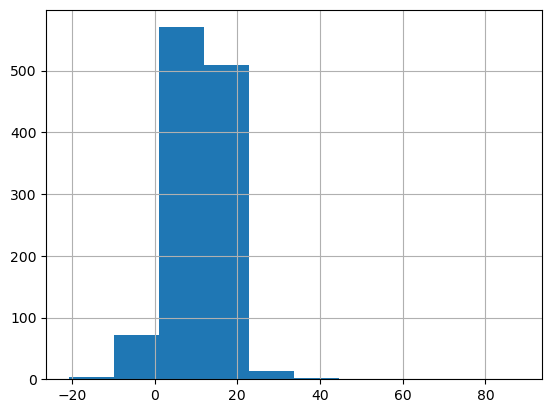

In [13]:
data['PER'].hist()

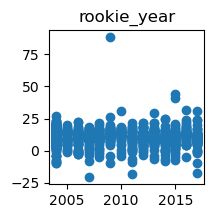

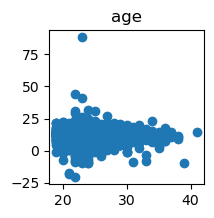

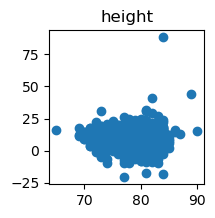

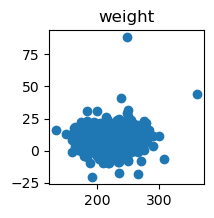

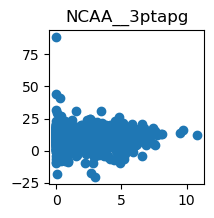

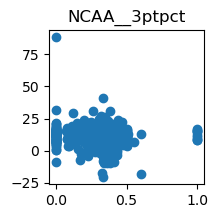

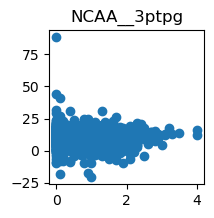

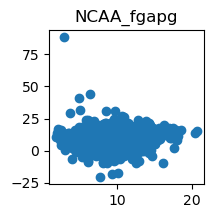

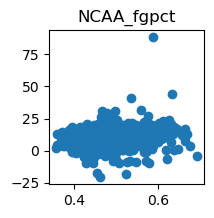

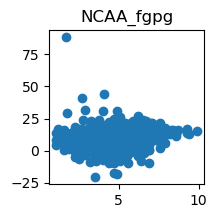

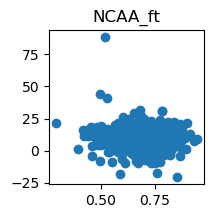

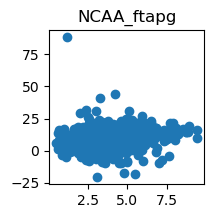

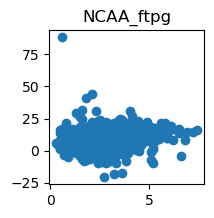

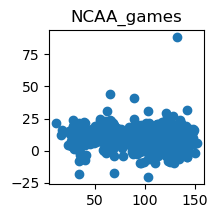

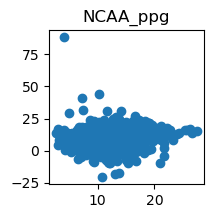

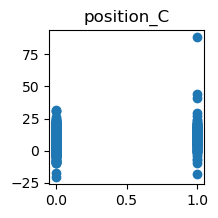

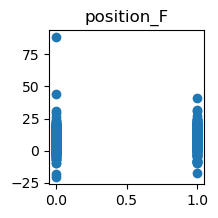

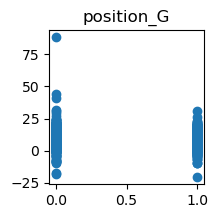

In [18]:
predictor_vars = numeric.columns[2:]

for c in predictor_vars:
    plt.figure(figsize=(2,2))
    plt.scatter(data[c],data['PER'])
    plt.title(c)
    plt.show()

In [19]:
#there is clearly one outlier - 
data.loc[data['PER']==max(data['PER']),:]

,index,name,PER,rookie_year,age,college,height,position,weight,NCAA__3ptapg,...,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg,position_C,position_F,position_G
619,620,Steven Hill,88.3,2009,23,University of Arkansas,84,C,248.0,0.0,...,0.589,1.7,0.519,1.2,0.6,132.0,4.0,1,0,0


In [27]:
#I was not able to confirm his PER rating so I'm going to drop the row.
data.drop(619,axis=0,inplace=True)

In [37]:
to_scale = numeric.columns[1:-3]

scale = preprocessing.StandardScaler().fit(data[to_scale])
scaled = data.copy()
scaled[to_scale] = scale.transform(data[to_scale])

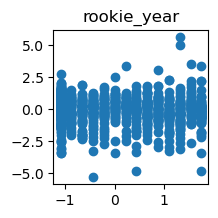

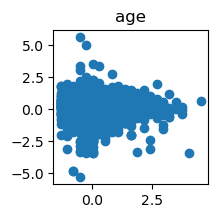

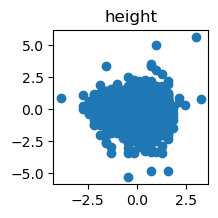

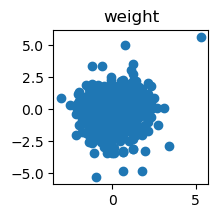

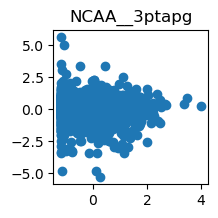

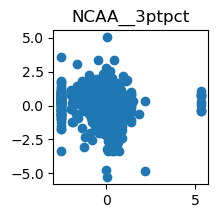

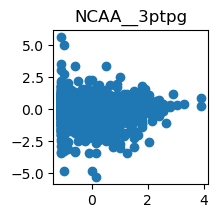

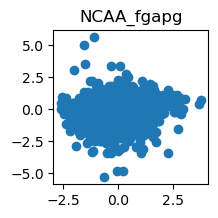

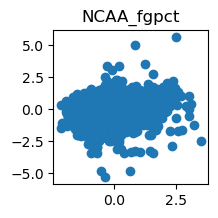

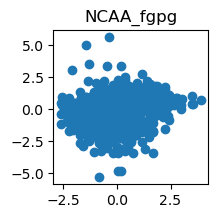

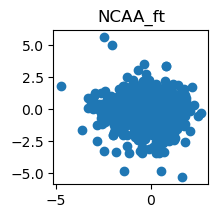

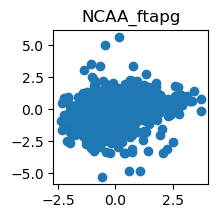

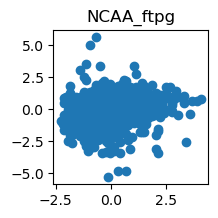

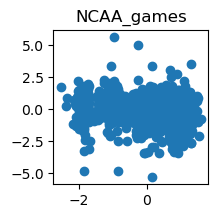

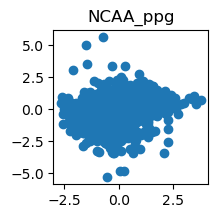

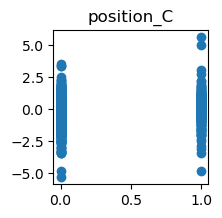

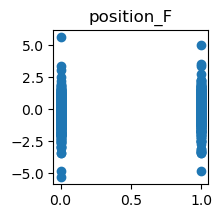

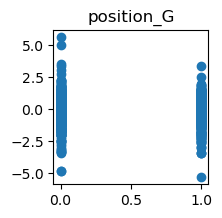

In [38]:
for c in predictor_vars:
    plt.figure(figsize=(2,2))
    plt.scatter(scaled[c],scaled['PER'])
    plt.title(c)
    plt.show()

In [46]:
predictor_vars = predictor_vars.drop('NCAA__3ptpct')

In [45]:
scaled.isna().sum()

index            0
name             0
PER              0
rookie_year      0
age              0
college          0
height           0
position         0
weight           0
NCAA__3ptapg     0
NCAA__3ptpct    80
NCAA__3ptpg      0
NCAA_fgapg       0
NCAA_fgpct       0
NCAA_fgpg        0
NCAA_ft          0
NCAA_ftapg       0
NCAA_ftpg        0
NCAA_games       0
NCAA_ppg         0
position_C       0
position_F       0
position_G       0
dtype: int64

In [54]:
reg = LinearRegression()
reg.fit(scaled[predictor_vars], scaled['PER'])
print(reg.score(scaled[predictor_vars],scaled['PER']))
reg.coef_

0.09833172063100004


array([-0.06384287, -0.02751054, -0.1101449 ,  0.02239706,  0.57567232,
       -0.3813035 , -0.6958461 ,  0.04875524,  0.84665449, -0.09464466,
       -0.26675288,  0.46399051, -0.09663605, -0.25378376,  0.2330169 ,
        0.24176284,  0.10137506])

array([-0.04800038,  0.        ,  0.        ,  0.02436834, -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.01817674,  0.15887378,  0.        ,
        0.        , -0.        ])